# NLP with Disaster Tweets 

The goal for this problem is to correctly predit whether or not a tweet is referring to a disaster or not bylearning how to differentiate
between words being used metaphorically or literally, such as the word "ABLAZE" as shown in the instance below:

<div style="text-align: center;">
<img src="tweet_screenshot.png" width="300"/>
<div/>

### problem description cont'd:
We will be using natural language processing in order to train an RNN model to correctly learn the application of these words based on the surrounding 
context. More detail regarding the RNN architecture later. First we will perform EDA to better understand the data. 

# EDA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
test = "nlp-getting-started/test.csv"
train = "nlp-getting-started/train.csv"

In [9]:
tweets_df = pd.read_csv(train)

In [11]:
tweets_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
tweets_df.shape

(7613, 5)

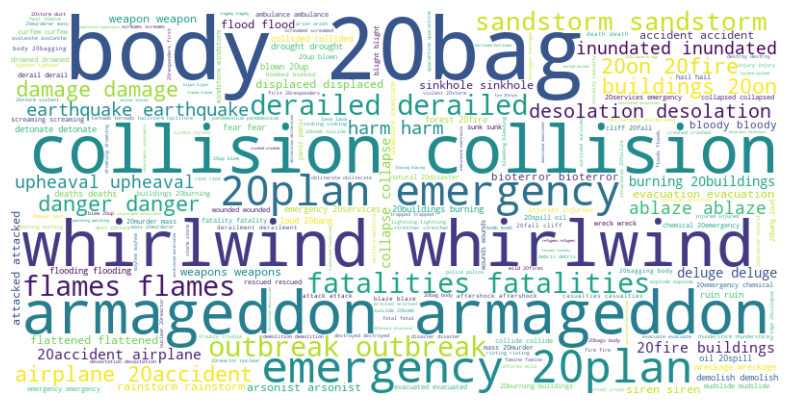

In [15]:
'''
Here we will visualize to see the most common keywords. This will give us a look into
what context may deleniate a true disaster tweet. However, this is not all encompassing
since not all disaster tweets have a keyword. 
'''

from wordcloud import WordCloud

keywords_df = tweets_df.dropna()

text = ' '.join(keywords_df['keyword'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

In [17]:
keywords_df.shape

(5080, 5)

Total keywords: 221


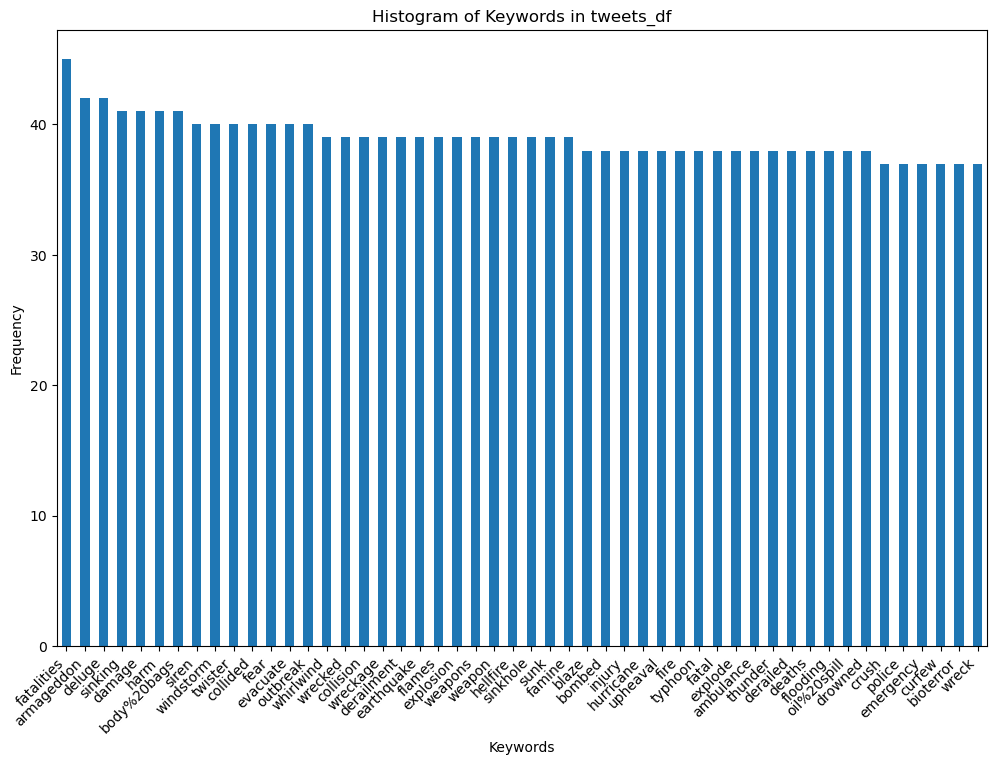

In [19]:
keyword_counts = tweets_df['keyword'].value_counts()

sorted_keyword_counts = keyword_counts.sort_values(ascending=False)

print("Total keywords:", sorted_keyword_counts.shape[0])

plt.figure(figsize=(12, 8))
sorted_keyword_counts[:50].plot(kind='bar')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Histogram of Keywords in tweets_df')
plt.xticks(rotation=45, ha='right')
plt.show()

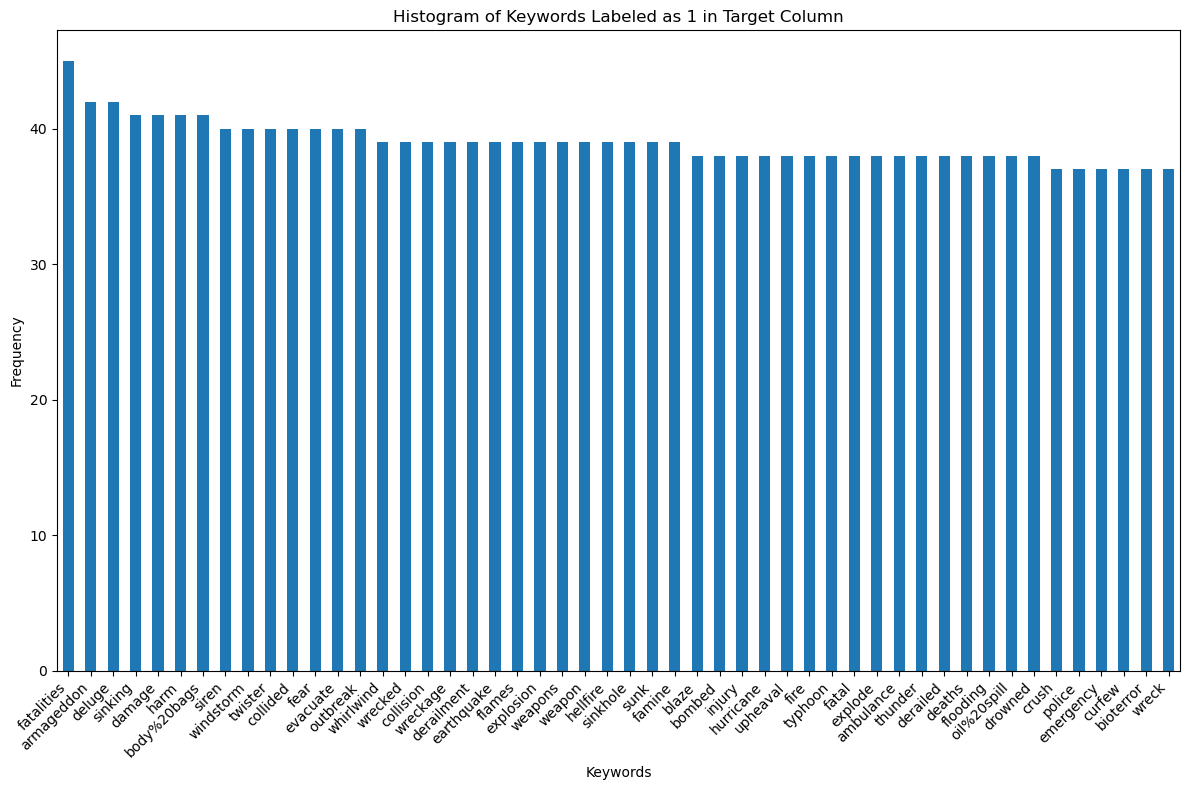

In [21]:
filtered_df = tweets_df[tweets_df['target'] == 1]

target_keyword_counts = filtered_df['keyword'].value_counts()

target_sorted_keyword_counts = keyword_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 8))  
ax = target_sorted_keyword_counts[:50].plot(kind='bar')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Histogram of Keywords Labeled as 1 in Target Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

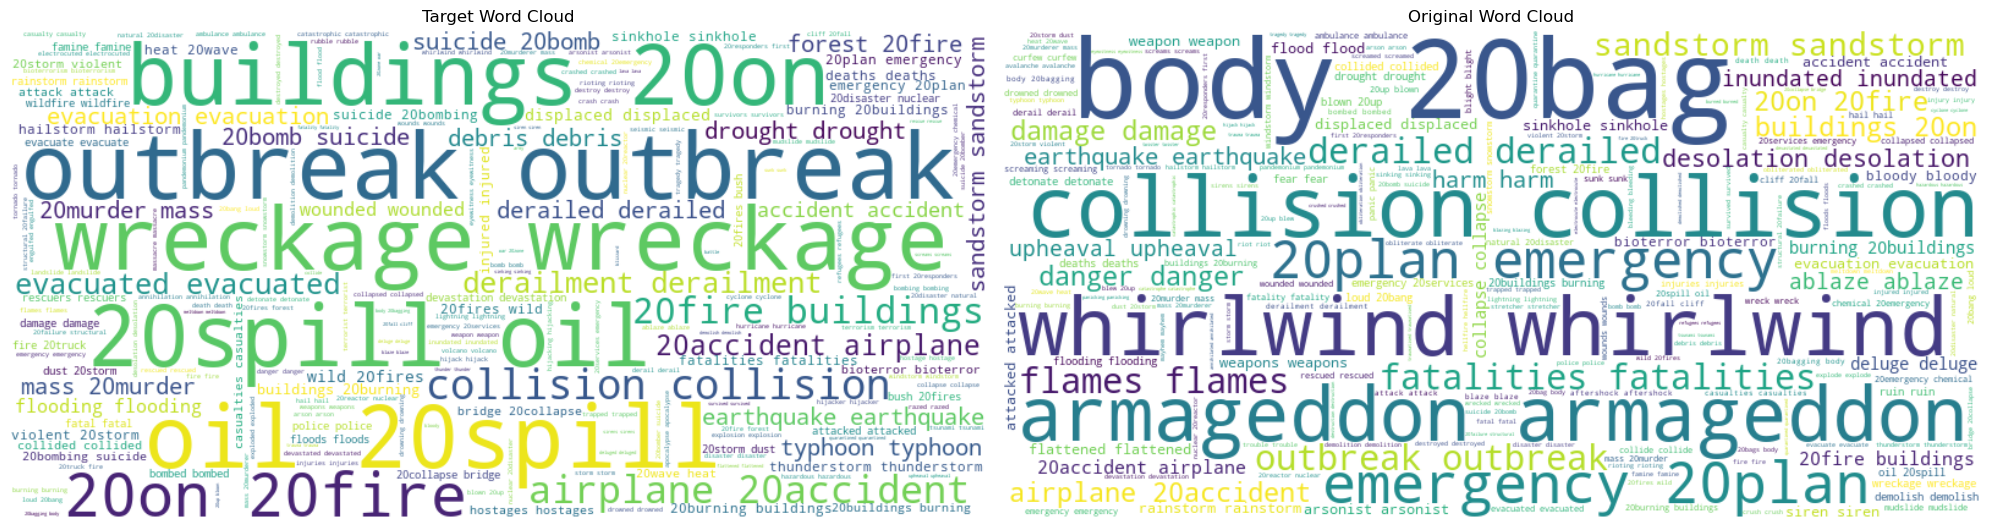

In [23]:
# let's create another wordcloud using words associated with the target and have it next to original for comparison

filtered_df = filtered_df.dropna()

target_text = ' '.join(filtered_df['keyword'].astype(str).tolist())

target_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(target_text)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# TARGET WORDCLOUD
axs[0].imshow(target_wordcloud, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Target Word Cloud')

# ORIGINAL WORDCLOUD
axs[1].imshow(wordcloud, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Original Word Cloud')

plt.tight_layout()
plt.show()

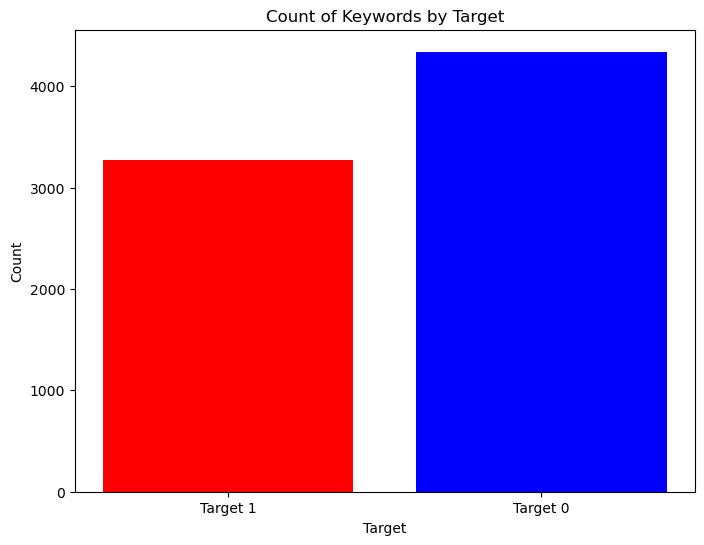

In [25]:
# plotting total amount of keywords labeled 1 and 0 respectively
keywords_target1 = tweets_df[tweets_df['target'] == 1]['keyword']
keywords_target0 = tweets_df[tweets_df['target'] == 0]['keyword']

count_target1 = len(keywords_target1)
count_target0 = len(keywords_target0)

plt.figure(figsize=(8, 6))
plt.bar(['Target 1', 'Target 0'], [count_target1, count_target0], color=['red', 'blue']) #red for real disaster blue for non-disaster
plt.title('Count of Keywords by Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [27]:
# visualizing df head again for convenience
tweets_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [29]:
# is location valuable info? let's take a look. First the total number of locations
location_count_non_nan = tweets_df['location'].apply(lambda x: x if pd.notna(x) else None).dropna().count()

print("Total non-null values in 'column_name:", location_count_non_nan)

Total non-null values in 'column_name: 5080


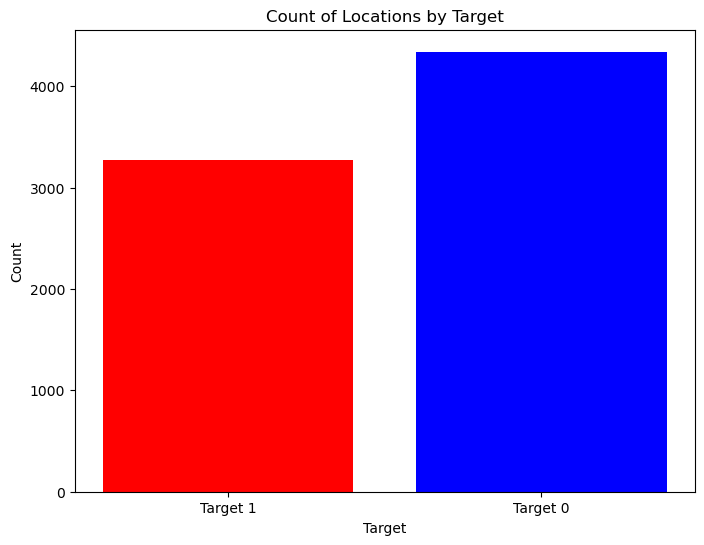

In [31]:
# plotting total amount of locations labeled 1 and 0 respectively
location_target1 = tweets_df[tweets_df['target'] == 1]['location']
location_target0 = tweets_df[tweets_df['target'] == 0]['location']

location_count_target1 = len(location_target1)
location_count_target0 = len(location_target0)

plt.figure(figsize=(8, 6))
plt.bar(['Target 1', 'Target 0'], [location_count_target1, location_count_target0], color=['red', 'blue']) #red for real disaster blue for non-disaster
plt.title('Count of Locations by Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

### ^^^ quick note: 
seems to be no variation because 'keyword' and 'location' columns have nan values associated with the exact same rows and therefore the 
result of correlated values is exactly the same between keyword and location. Because of this, these two columns are redundant and the location 
column is not valuable as it is collinear with the 'keyword' column. We will drop it.

In [34]:
tweets_df = tweets_df.drop('location', axis=1)

tweets_df.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [36]:
# also removing id column as it will not be valuable for our RNN

tweets_df = tweets_df.drop('id', axis=1)

tweets_df.head()

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [38]:
# quick look into longest text string in a tweet for padding purposes later
max_length = tweets_df['text'].str.len().max()

max_length_text = tweets_df.loc[tweets_df['text'].str.len().idxmax(), 'text']

print("Length of the longest string in 'text' column:", max_length)
print("Text corresponding to the maximum length:")
print(max_length_text)

Length of the longest string in 'text' column: 157
Text corresponding to the maximum length:
when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????


In [40]:
# Example assuming preprocessing has already been done and text is tokenized
max_words = tweets_df['text'].apply(lambda x: len(x.split())).max()

print("Maximum number of words in any single 'text' string:", max_words)

Maximum number of words in any single 'text' string: 31


In [42]:
# preprocessing text

import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')

def preprocess_text(text):
    if pd.isna(text):
        return ''
        
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    tokens = text.split()
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    text = ' '.join(tokens)
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sethmartin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Thought process on how I will approach preprocessing for training
Because we are given two valuable columns ('keyword' and 'text'), I would like to preprocess them separately and then later combine the sequences to
train our RNN. 

In [48]:
tweets_df['keyword'] = tweets_df['keyword'].apply(preprocess_text)

max_words_keyword = 6000
tokenizer_keyword = Tokenizer(num_words=max_words_keyword)
tokenizer_keyword.fit_on_texts(tweets_df['keyword'])
sequences_keyword = tokenizer_keyword.texts_to_sequences(tweets_df['keyword'])
padded_sequences_keyword = pad_sequences(sequences_keyword)

In [49]:
tweets_df['text'] = tweets_df['text'].apply(preprocess_text)

max_words_text = 10000 
tokenizer_text = Tokenizer(num_words=max_words_text)
tokenizer_text.fit_on_texts(tweets_df['text'])
sequences_text = tokenizer_text.texts_to_sequences(tweets_df['text'])
max_sequence_length = 150
padded_sequences_text = pad_sequences(sequences_text, maxlen=max_sequence_length)

### Building RNN Model
I am choosing an LTSM model due to its ability to learn context of text in NLP very well. I am using 3 layers, which is typically the max amount used in most cases. LeakyRelu is my choice of activation function due to its robustness against vanishing gradients. Sigmoid function due to binary target value of the problem. 

In [53]:
# prepare data
'''
Because our training dataset consists of 7613 rows and our training set lacks the target column, I will do an 80/20 split on 
the training data to dedicate a dev/val set for the model. This will allow us to properly have labeled items for our loss function. 
'''

from sklearn.model_selection import train_test_split

df_keyword = pd.DataFrame(padded_sequences_keyword)
df_text = pd.DataFrame(padded_sequences_text)

X = pd.concat([df_keyword, df_text], axis=1)  
y = tweets_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
X.shape

(7613, 151)

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.layers import LeakyReLU

def lstm_model(max_words, max_sequence_length, embedding_dim):
    model = Sequential()
    
    model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(LeakyReLU(alpha=0.3))  
    model.add(LSTM(64, return_sequences=True))
    model.add(LeakyReLU(alpha=0.3)) 
    model.add(LSTM(32))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

max_words = 10000
max_sequence_length = 200
embedding_dim = 100  

model = lstm_model(max_words, max_sequence_length, embedding_dim)
model.summary()

/Users/sethmartin/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/sethmartin/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [77]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - accuracy: 0.6228 - loss: 0.6375 - val_accuracy: 0.7991 - val_loss: 0.4537
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.8677 - loss: 0.3371 - val_accuracy: 0.7951 - val_loss: 0.4592
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 160ms/step - accuracy: 0.9159 - loss: 0.2321 - val_accuracy: 0.7761 - val_loss: 0.5796
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.9453 - loss: 0.1677 - val_accuracy: 0.7505 - val_loss: 0.6586
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.9556 - loss: 0.1341 - val_accuracy: 0.7597 - val_loss: 0.7931
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.9681 - loss: 0.1063 - val_accuracy: 0.7617 - val_loss: 0.7970
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.9759 - loss: 0.0716 - val_accuracy: 0.7262 - val_loss: 0.9418
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 162ms/step - accuracy: 0.9730 - loss: 0

In [79]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)  

# computing F1 score. kaggle notebook uses f1 as evaluator
f1 = f1_score(y_val, y_pred)
print(f"F1 Score: {f1:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
F1 Score: 0.6991


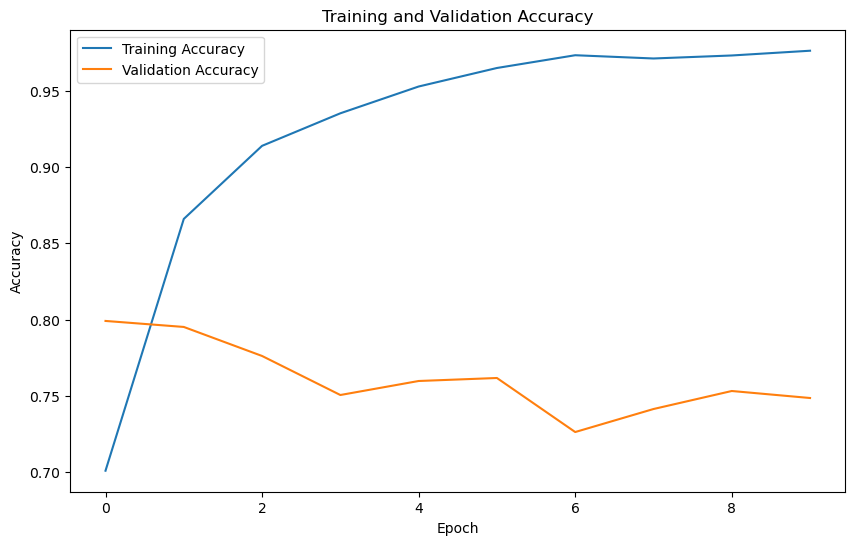

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Initial analysis 
Initial accuracy of almost 75% on validation data and an F1 score of .699 indicates a decent predictive model, but the obvious gap between the training accuracy tells us that this model is overfitting. First, I will ereduce the complexity of the model by removing a layer, retraining and then see if a stop loss will benefit further. 

In [85]:
def lstm_model_2(max_words, max_sequence_length, embedding_dim):
    model = Sequential()
    
    model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(LeakyReLU(alpha=0.3))  
    model.add(LSTM(64))
    model.add(LeakyReLU(alpha=0.3)) 
    #model.add(LSTM(32))  COMMENTING OUT FOR VISIBILITY OF WHAT I AM DOING
    #model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model2 = lstm_model_2(max_words, max_sequence_length, embedding_dim)
model2.summary()

/Users/sethmartin/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/sethmartin/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [87]:
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

val_loss2, val_accuracy2 = model2.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy2:.4f}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.6332 - loss: 0.6179 - val_accuracy: 0.7879 - val_loss: 0.4549
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.8762 - loss: 0.3243 - val_accuracy: 0.7505 - val_loss: 0.5251
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step - accuracy: 0.9199 - loss: 0.2188 - val_accuracy: 0.7754 - val_loss: 0.6008
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.9494 - loss: 0.1446 - val_accuracy: 0.7603 - val_loss: 0.6885
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.9623 - loss: 0.1103 - val_accuracy: 0.7597 - val_loss: 0.8129
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.9642 - loss: 0.0862 - val_accuracy: 0.7590 - val_loss: 0.9709
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.9729 - loss: 0.0732 - val_accuracy: 0.7387 - val_loss: 1.1023
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 0.9782 - loss: 0

^^^ very little improvement, let's try some additional regularization. 

In [96]:
# adding dropout layers
from tensorflow.keras.layers import Dropout

def lstm_model_3(max_words, max_sequence_length, embedding_dim):
    model = Sequential()
    
    model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(LeakyReLU(alpha=0.3))  
    model.add(Dropout(0.3))
    
    model.add(LSTM(64, return_sequences=True))
    model.add(LeakyReLU(alpha=0.3)) 
    model.add(Dropout(0.3))
    
    model.add(LSTM(32))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [98]:
model3= lstm_model_3(max_words, max_sequence_length, embedding_dim)
model3.summary()

/Users/sethmartin/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/sethmartin/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [100]:
history3 = model3.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

val_loss3, val_accuracy3 = model3.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy3:.4f}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 160ms/step - accuracy: 0.5978 - loss: 0.6555 - val_accuracy: 0.7938 - val_loss: 0.4533
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.8634 - loss: 0.3505 - val_accuracy: 0.7899 - val_loss: 0.4685
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - accuracy: 0.9154 - loss: 0.2462 - val_accuracy: 0.7636 - val_loss: 0.5300
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 168ms/step - accuracy: 0.9431 - loss: 0.1810 - val_accuracy: 0.7676 - val_loss: 0.6249
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 170ms/step - accuracy: 0.9544 - loss: 0.1421 - val_accuracy: 0.7656 - val_loss: 0.6948
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 0.9665 - loss: 0.1124 - val_accuracy: 0.7590 - val_loss: 0.8050
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 0.9710 - loss: 0.0895 - val_accuracy: 0.7485 - val_loss: 0.9320
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - accuracy: 0.9736 - loss: 0

In [102]:
y_pred = model3.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)  

# computing F1 score. kaggle notebook uses f1 as evaluator
f1 = f1_score(y_val, y_pred)
print(f"F1 Score: {f1:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
F1 Score: 0.7036


# Conclusion

Although the model slightly improved by about a percentage point compared to the original model, it is still overfitting despite the regularization 
added. An early stop at the first epoch would give the best results. However, it seems as though the archecture is too complex for the model and less layers and nodes in the layer would probably result in a stronger model for this data set. The architecture should be reconsidered for future implementation. Final model accuracy sits at 79% if I were to stop at first epoch. 